# Tutorial: Train single cell data using random conext method

## Introduction

This tutorial demonstrates the use of **scGenAI** for training a model to predict cell types from single-cell RNA sequencing (scRNA-seq) data. In this tutorial, we apply the **random context** method for generating input sequences and use the **LLaMA** model as the foundational architecture.

Key points to consider:

1. The dataset used for this tutorial consists of **40 cells**, selected for demonstration purposes. For practical applications, it is advised to replace this with a larger, representative dataset.
2. In this tutorial, we employ the **LLaMA** model backbone and utilize the **random context** method to create the training context.
3. Logging into **Hugging Face** with a token is required when using the LLaMA model for the first time. This requirement is specific to LLaMA and does not apply to other model architectures supported by **scGenAI**.


### Login Huggingface (ONLY required for the FIRST TIME use of llama model template)

Again, this is needed for the first time use llama as the model template

In [7]:
from huggingface_hub import login
import getpass

def login_to_huggingface():
    """
    Prompts the user to securely enter their Hugging Face token and logs them into the Hugging Face Hub.
    """
    token = getpass.getpass(prompt='Please enter your Hugging Face token: ')
    login(token=token)
    print("Successfully logged in to Hugging Face!")

# Call the function to log in
login_to_huggingface()

Please enter your Hugging Face token:  ········


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/ubuntu/.cache/huggingface/token
Login successful
Successfully logged in to Hugging Face!


## Train the model using random context (Multiple GPU)

The training process can be easily initiated by calling the `run_training_from_config` function in **scGenAI** with input files specified in a configuration YAML file. Example template YAML files can be found in the `scgenai/examples/config_templates` folder of the package. These templates provide the necessary structure for defining training parameters, model configurations, and input data locations.

In [10]:
from scGenAI.training.train import run_training_from_config

model_dir: /home/ubuntu/scgenai/examples/testrun/test1/
train_file: /home/ubuntu/scgenai/examples/data/example_train.h5ad
val_file: /home/ubuntu/scgenai/examples/data/example_val.h5ad
log_dir: /home/ubuntu/scgenai/examples/logs/
output_dir: /home/ubuntu/scgenai/examples/output
seed: 1314521
cache_dir: /home/ubuntu/scgenai/examples/tmp/cache
mode: Train
min_cells: 2
target_feature: ct
multiomics: No
keepIntermediateFiles: No
savelog: Yes
savesetting: Yes
model_backbone_name: llama
model_backbone_size: small
context_method: random
num_bins: 10
optimizer: AdamW
weight_decay: 0.01
depth: 2
max_length: 5120
batch_size: 1
learning_rate: 1e-05
num_epochs: 20
world_size: 1
evaluate_during_training: True
hidden_size: 256
num_layers: 6
num_heads: 4
intermediate_size: 1024
stride: 2560


2024-10-15 20:16:42.260 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 0, Total GPUs used: 4
2024-10-15 20:16:42.262 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 2, Total GPUs used: 4
2024-10-15 20:16:42.267 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 3, Total GPUs used: 4
2024-10-15 20:16:42.270 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 1, Total GPUs used: 4
2024-10-15 20:16:44.510 | INFO     | scGenAI.training.train:model_train_and_eval:214 - Total number of trainable parameters: 74945796; Max Sequence Legth: 2560 genes
Epoch 1/20: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s, GPU_ID=1, train_accuracy=0.2, train_loss=1.38]  

Evaluating Epoch 1/20: 100%|██████████| 40/40 [00:08<00:00,  4.58it/s]
2024-10-15 20:17:01.387 | INFO     | scGenAI.training.train:evaluate_and_save_pre

Plot saved to /home/ubuntu/scgenai/examples/testrun/test1/train_summary.pdf


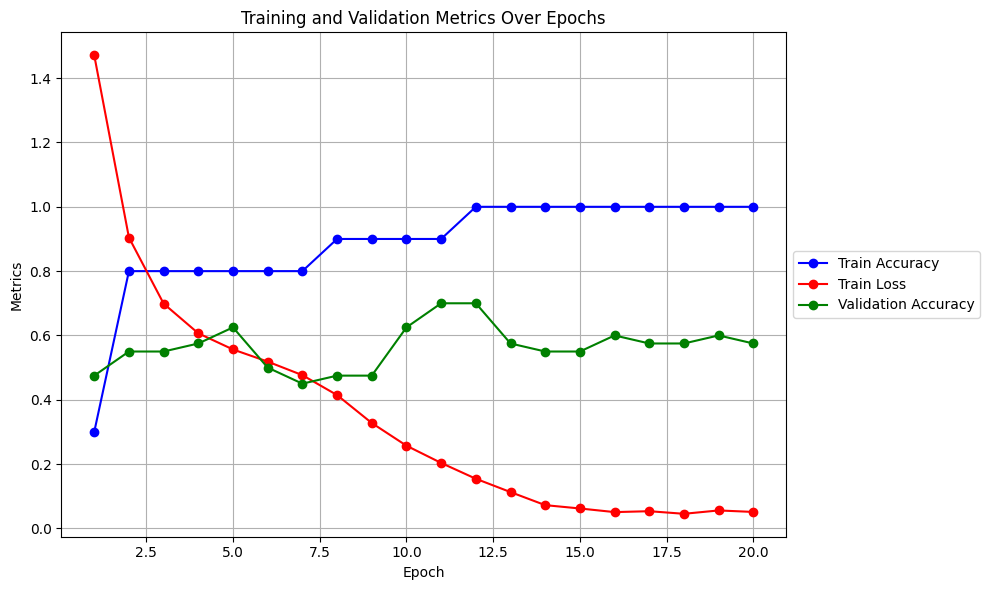

In [11]:
config_file = '/home/ubuntu/scgenai/tutorials/yaml/config_random_context_template_llama.yaml'
run_training_from_config(config_file)

## Post-Training Model and Results

Upon completion of the training, the trained model will be saved in the `model_dir` as defined in the configuration file. Within this directory, two subfolders will be created: `best_model` and `last_model`. The `best_model` folder contains the model that achieved the highest training performance, while the `last_model` contains the model from the final epoch. Additionally, a `combined_epoch_results.csv` file will be generated in the `model_dir`, summarizing the training performance metrics across all epochs.

### Training Summary

In addition to the output summary files generated after training, the training summary can be directly accessed in Python by loading the saved configuration file.


In [16]:
from scGenAI.config import Config
from scGenAI.data.postprocess import TrainSummary

In [17]:
config = Config(config_file)
summary = TrainSummary(config.model_dir)
dfsummary = summary.table()
dfsummary

,Epoch,Validation Accuracy,Train Loss,Train Accuracy
0,1,0.475,1.471285,0.3
1,2,0.550,0.904521,0.8
2,3,0.550,0.698932,0.8
3,4,0.575,0.606600,0.8
4,5,0.625,0.556357,0.8
5,6,0.500,0.518641,0.8
6,7,0.450,0.476483,0.8
7,8,0.475,0.414584,0.9
8,9,0.475,0.327680,0.9
9,10,0.625,0.257125,0.9


It can also be plotted using the `summary.plot`:

Plot saved to /home/ubuntu/scgenai/examples/testrun/test1/train_summary.pdf


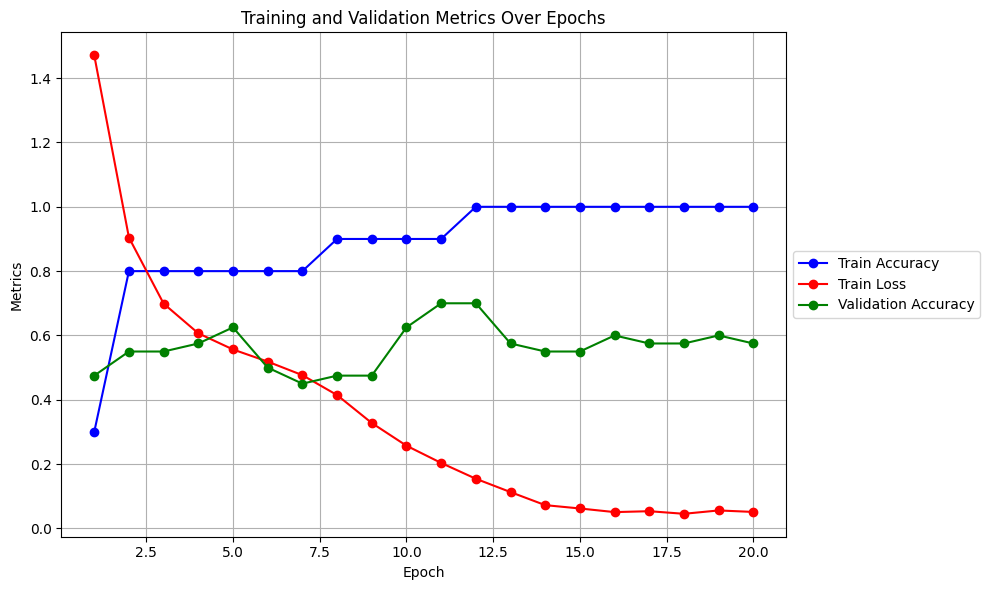

In [18]:
summary.plot(saveplot=True)

## Prediction Using the Trained Model

Similar to the training step, predictions can be run using the `run_prediction_from_config` function in scGenAI with a simple configuration file. Unlike the training configuration, the prediction configuration file only requires the following parameters to be defined: `mode`, `predict_file`, `batch_size`, `model_dir`, and `outputfile`. All other parameters will be adopted from the trained model.


In [21]:
from scGenAI.prediction.predict import run_prediction_from_config

In [22]:
pred_config_file = '/home/ubuntu/scgenai/tutorials/yaml/config_prediction_template.yaml'
run_prediction_from_config(pred_config_file)

model_dir: /home/ubuntu/scgenai/examples/testrun/test1/best_model/
predict_file: /home/ubuntu/scgenai/examples/data/example_val.h5ad
log_dir: /home/ubuntu/scgenai/examples/logs
output_dir: /home/ubuntu/scgenai/examples/output
seed: 1314521
mode: Predict
min_cells: 2
multiomics: No
keepIntermediateFiles: No
savelog: No
savesetting: Yes
model_backbone_name: llama
model_backbone_size: small
context_method: random
num_bins: 10
optimizer: AdamW
weight_decay: 0.01
depth: 2
max_length: 5120
batch_size: 1
learning_rate: 1e-05
num_epochs: 30
world_size: 1
evaluate_during_training: False
hidden_size: 768
num_layers: 12
num_heads: 12
intermediate_size: 1024
stride: 2560


2024-10-15 20:41:03.560 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 0, Total GPUs used: 4
2024-10-15 20:41:03.570 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 1, Total GPUs used: 4
2024-10-15 20:41:03.580 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 2, Total GPUs used: 4
2024-10-15 20:41:03.582 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 3, Total GPUs used: 4
GPU 3 Predicting: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]
2024-10-15 20:41:09.427 | INFO     | scGenAI.utils.distributed:cleanup:33 - Cleaned up DDP environment
2024-10-15 20:41:09.427 | INFO     | scGenAI.utils.distributed:cleanup:33 - Cleaned up DDP environment
2024-10-15 20:41:09.427 | INFO     | scGenAI.utils.distributed:cleanup:33 - Cleaned up DDP environment
2024-10-15 20:41:09.427 | INFO     | scGenAI.utils.di

The prediction output is a CSV file, as defined in the configuration file. It contains the original metadata extracted from the input prediction file (`obs` slot) along with three additional columns: `context_id`, `PredictedFeature`, and `prediction_score`. 

- `context_id` represents the context used to determine the prediction for the corresponding cell. 
- `PredictedFeature` is the final predicted feature for the cell using the trained model. 
- `prediction_score` indicates the confidence level of the prediction, with a maximum value of 1.

For example in this tutorials:

In [24]:
import pandas as pd
preconfig = Config(pred_config_file)
dfprediction = pd.read_csv(preconfig.outputfile)
dfprediction.head()

,index,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.0.8,seurat_clusters,sample,sampleId,projectId,sampleType,...,subjectId,age,gender,processStatus,predicted_cell_type,ct,cell_barcode,context_id,PredictedFeature,prediction_score
0,TGCCCTAGTCTTGATG-1--GSM5515744,SeuratProject,2306,871,11,11,GSM5515744,GSM5515744,GSE181989,Normal,...,NaN,NaN,NaN,QC pass,9:granulocyte,Granulocyte-monocyte progenitor (GMP),TGCCCTAGTCTTGATG-1--GSM5515744,1_TGCCCTAGTCTTGATG-1--GSM5515744_window_0,Granulocyte-monocyte progenitor (GMP),0.616799
1,TGTTCCGGTCACACGC-1--GSM5515744,SeuratProject,1637,665,6,6,GSM5515744,GSM5515744,GSE181989,Normal,...,NaN,NaN,NaN,QC pass,13:cDC2,Granulocyte-monocyte progenitor (GMP),TGTTCCGGTCACACGC-1--GSM5515744,3_TGTTCCGGTCACACGC-1--GSM5515744_window_1,Granulocyte-monocyte progenitor (GMP),0.969203
2,TGTCCCAGTTCAGACT-1--GSM5515744,SeuratProject,1935,805,6,6,GSM5515744,GSM5515744,GSE181989,Normal,...,NaN,NaN,NaN,QC pass,13:cDC2,Granulocyte-monocyte progenitor (GMP),TGTCCCAGTTCAGACT-1--GSM5515744,2_TGTCCCAGTTCAGACT-1--GSM5515744_window_2,Granulocyte-monocyte progenitor (GMP),0.879183
3,AACACGTGTGCACGAA-1--GSM5515744,SeuratProject,2053,780,25,25,GSM5515744,GSM5515744,GSE181989,Normal,...,NaN,NaN,NaN,QC pass,13:cDC2,Granulocyte-monocyte progenitor (GMP),AACACGTGTGCACGAA-1--GSM5515744,2_AACACGTGTGCACGAA-1--GSM5515744_window_3,Granulocyte-monocyte progenitor (GMP),0.935869
4,ATCATGGCAAAGAATC-1--GSM5515744,SeuratProject,1983,788,6,6,GSM5515744,GSM5515744,GSE181989,Normal,...,NaN,NaN,NaN,QC pass,4:hematopoietic stem cell,Granulocyte-monocyte progenitor (GMP),ATCATGGCAAAGAATC-1--GSM5515744,0_ATCATGGCAAAGAATC-1--GSM5515744_window_4,Granulocyte-monocyte progenitor (GMP),0.666700
